# NOTEBOOK FOR THE ANALYSIS OF SINGLE-NUCLEI RNA-SEQUENCING DATA FROM LFSMB1R

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/LFSMB1R-Nuclei_scanpy.h5ad'  # the file that will store the analysis results


## READ IN THE DATA FOR LFSMB1R-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [4]:
adata = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMB1R/LFSMB1R-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()
adata

# make some metadata
adata.obs['sample'] = "LFSMB1R"
adata.obs['technology'] = "Nuclei"
adata.obs['patient'] = "LFSMB"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-ST1R-ST1R-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
adata.obs

,sample,technology,patient
AAACCTGAGCACCGCT-1,ST1R,Nuclei,ST
AAACCTGGTGATAAGT-1,ST1R,Nuclei,ST
AAACCTGGTGCGAAAC-1,ST1R,Nuclei,ST
AAACGGGTCGAGAGCA-1,ST1R,Nuclei,ST
AAACGGGTCGTCTGCT-1,ST1R,Nuclei,ST
...,...,...,...
TTTGTCACATTCGACA-1,ST1R,Nuclei,ST
TTTGTCAGTCCGAGTC-1,ST1R,Nuclei,ST
TTTGTCAGTTTGTTGG-1,ST1R,Nuclei,ST
TTTGTCATCCGCAGTG-1,ST1R,Nuclei,ST


In [6]:
scrub = scr.Scrublet(
        counts_matrix=adata.X,
        expected_doublet_rate=0.06,  # Default is 0.1
        random_state=0)

In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.9%
Elapsed time: 1.3 seconds


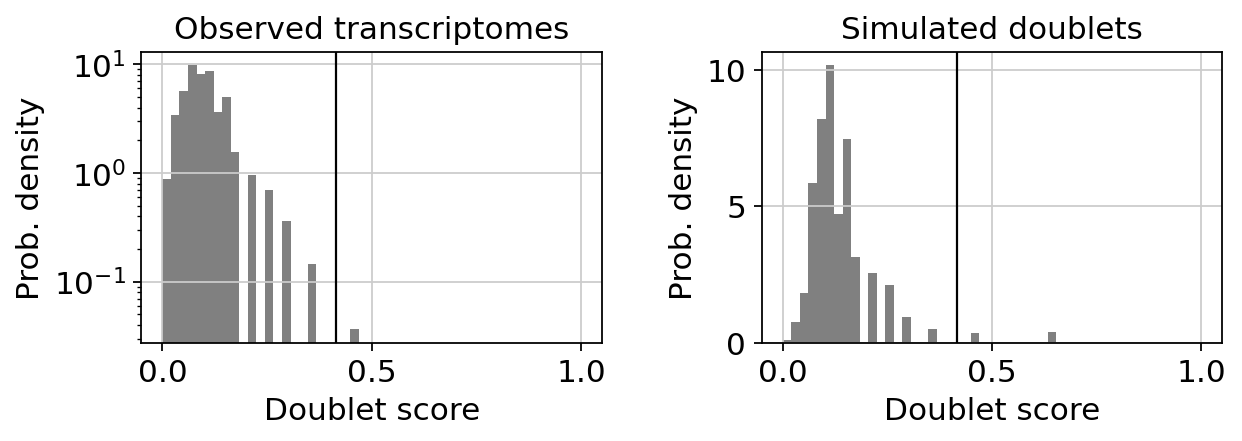

In [8]:
scrub.plot_histogram();

In [9]:
adata.obs['scrublet__predicted_multiplet'] = scrub.predicted_doublets_
adata.obs['scrublet__multiplet_scores'] = scrub.doublet_scores_obs_
adata.obs['scrublet__multiplet_zscores'] = scrub.z_scores_

In [10]:
adata.obs

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores
AAACCTGAGCACCGCT-1,ST1R,Nuclei,ST,False,0.058513,-14.350538
AAACCTGGTGATAAGT-1,ST1R,Nuclei,ST,False,0.115483,-6.036352
AAACCTGGTGCGAAAC-1,ST1R,Nuclei,ST,False,0.095485,-7.828092
AAACGGGTCGAGAGCA-1,ST1R,Nuclei,ST,False,0.087379,-8.788703
AAACGGGTCGTCTGCT-1,ST1R,Nuclei,ST,False,0.030928,-28.995586
...,...,...,...,...,...,...
TTTGTCACATTCGACA-1,ST1R,Nuclei,ST,False,0.182609,-2.917936
TTTGTCAGTCCGAGTC-1,ST1R,Nuclei,ST,False,0.026915,-33.496473
TTTGTCAGTTTGTTGG-1,ST1R,Nuclei,ST,False,0.073892,-10.852097
TTTGTCATCCGCAGTG-1,ST1R,Nuclei,ST,False,0.080235,-9.795756


In [11]:
# remove predicted doublets
adata = adata[adata.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


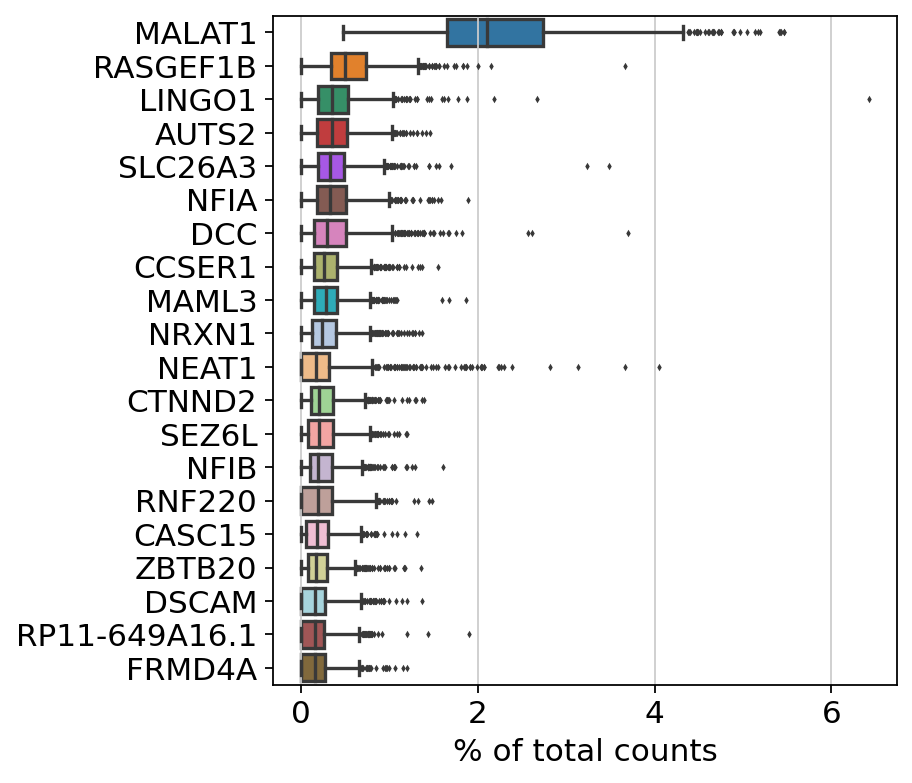

In [12]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [13]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16296 genes that are detected in less than 3 cells


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [14]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


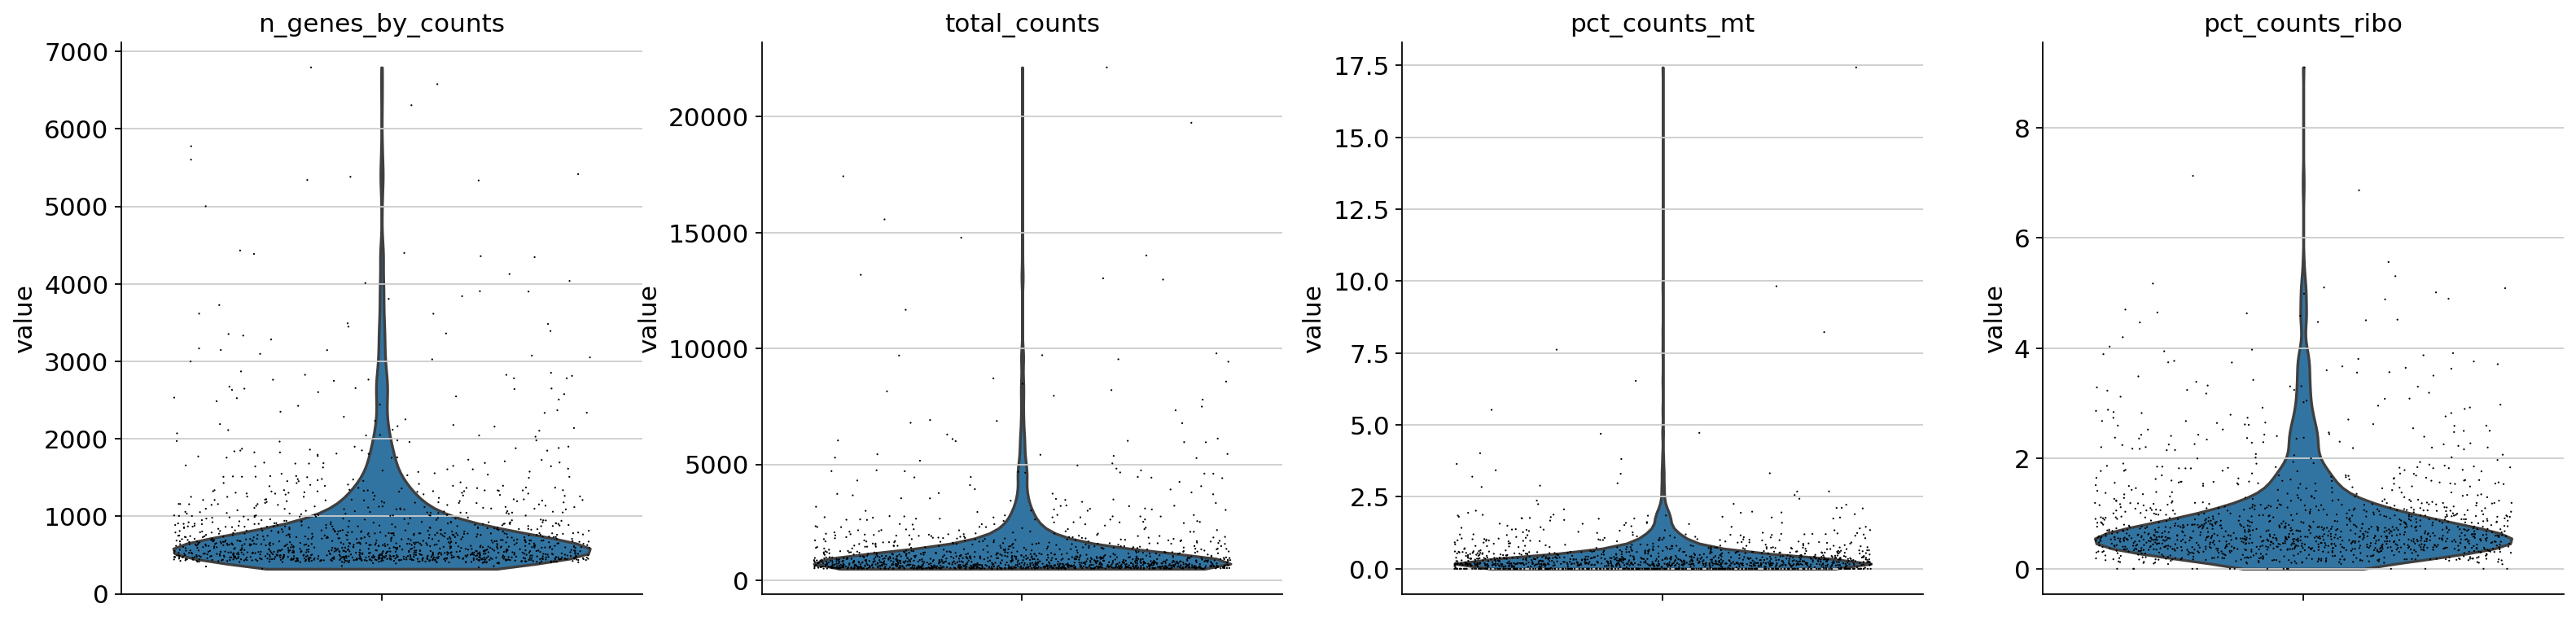

In [15]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

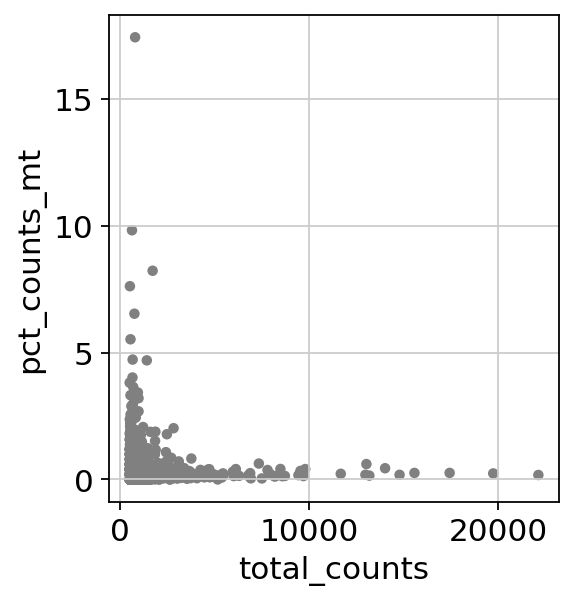

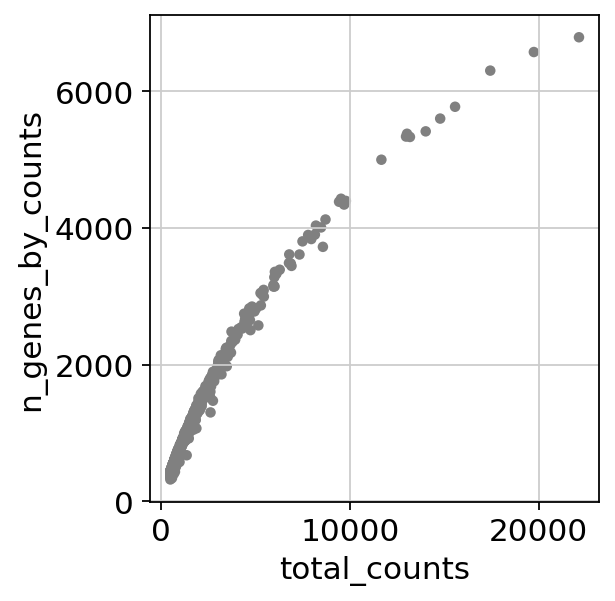

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
# do the actual filtering by slicing the object
adata = adata[300 < adata.obs.n_genes_by_counts, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_ribo < 10, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata

View of AnnData object with n_obs × n_vars = 1322 × 16442
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [19]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

878.4697428139183
1266.6746826171875


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


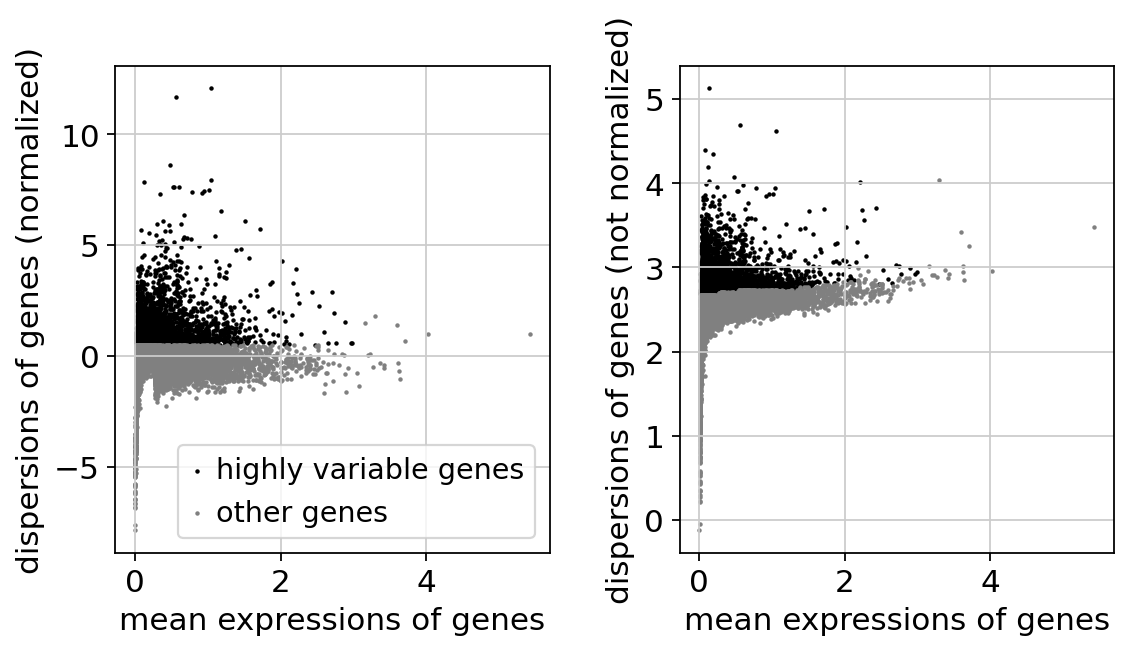

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
# set the raw attribute of anndata
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [27]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


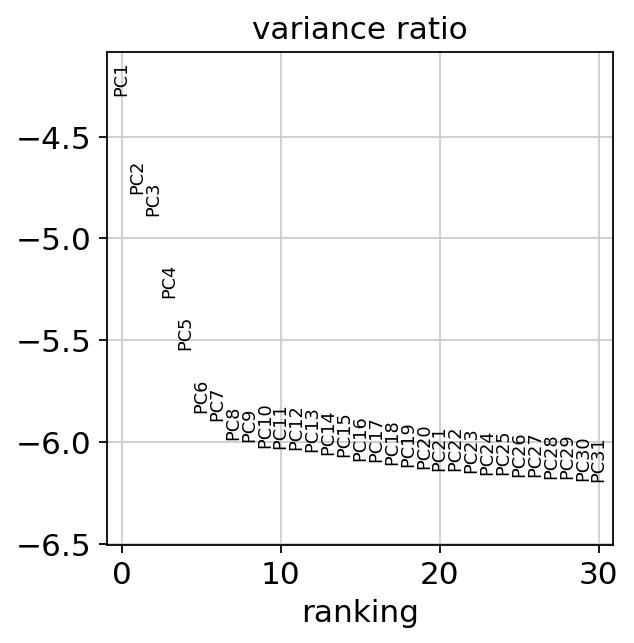

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=6)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.4)
sc.tl.leiden(adata, resolution= 0.4)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


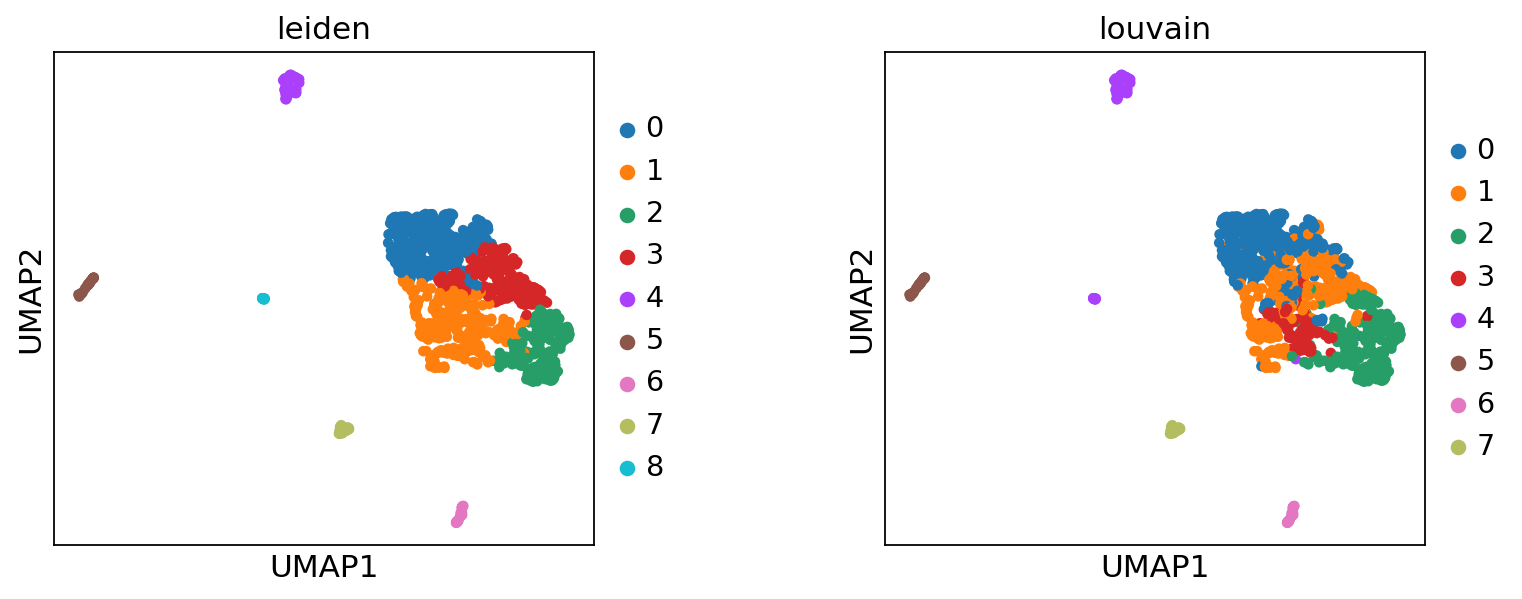

In [34]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_ST1R-Nuclei.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


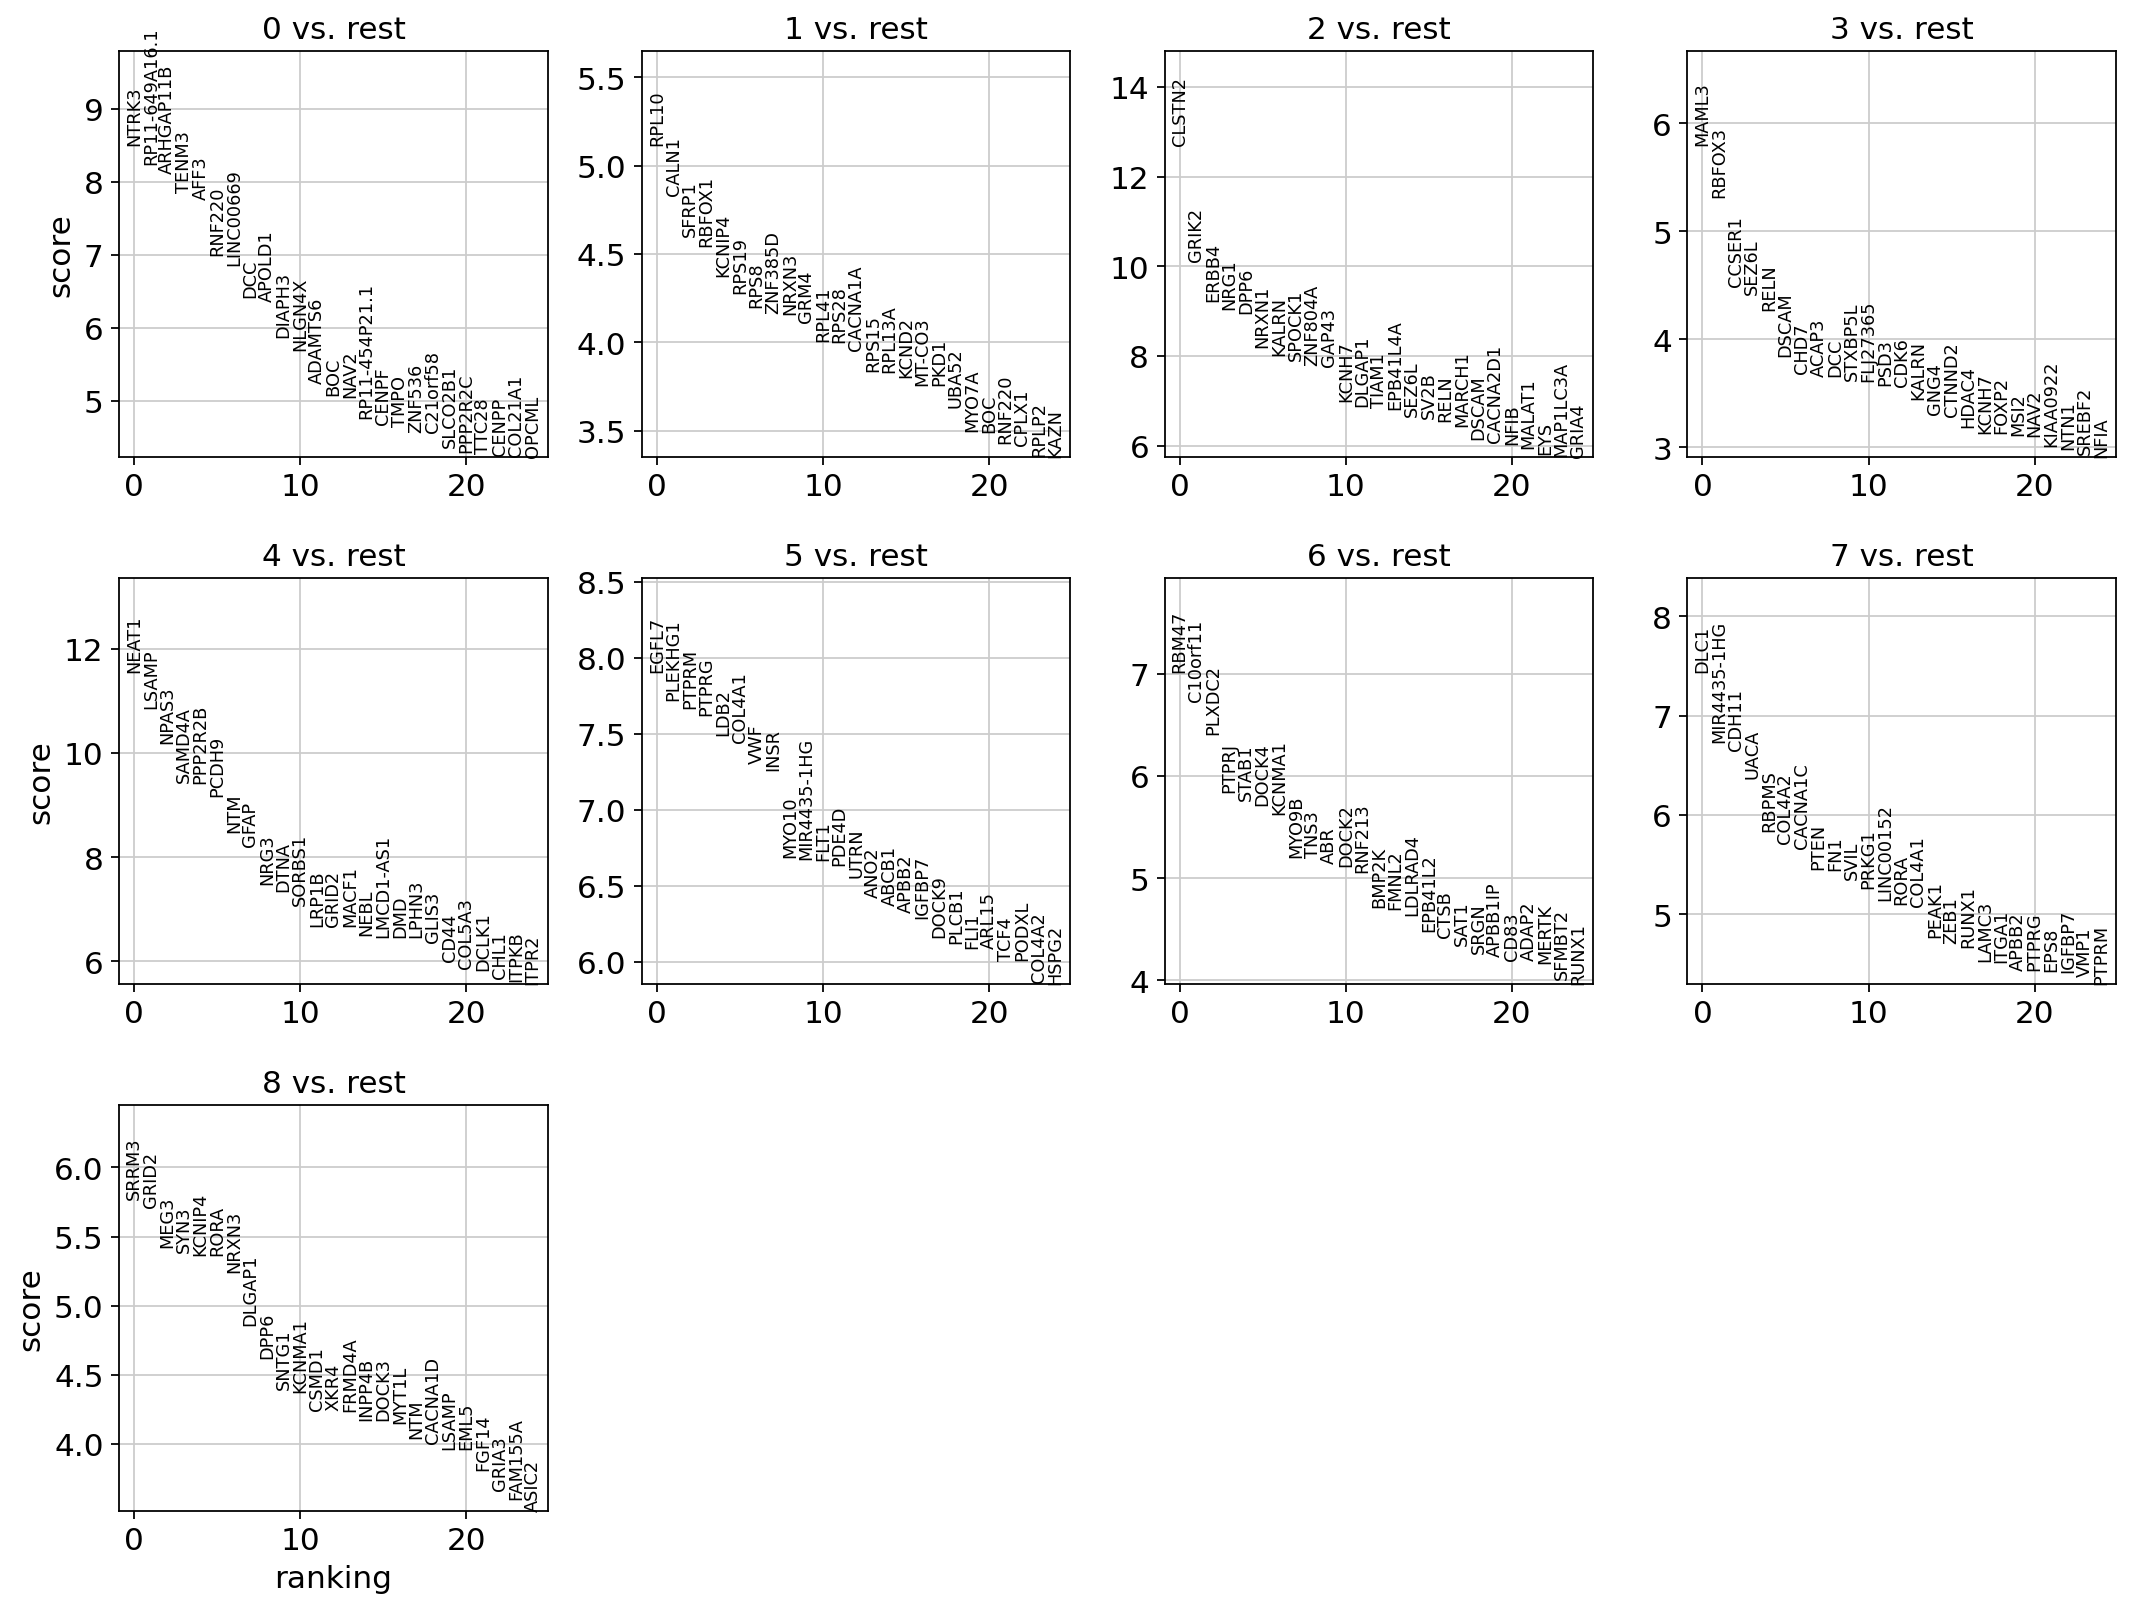

In [31]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_ST1R-Nuclei_leiden.pdf")

In [32]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,NTRK3,RPL10,CLSTN2,MAML3,NEAT1,EGFL7,RBM47,DLC1,SRRM3
1,RP11-649A16.1,CALN1,GRIK2,RBFOX3,LSAMP,PLEKHG1,C10orf11,MIR4435-1HG,GRID2
2,ARHGAP11B,SFRP1,ERBB4,CCSER1,NPAS3,PTPRM,PLXDC2,CDH11,MEG3
3,TENM3,RBFOX1,NRG1,SEZ6L,SAMD4A,PTPRG,PTPRJ,UACA,SYN3
4,AFF3,KCNIP4,DPP6,RELN,PPP2R2B,LDB2,STAB1,RBPMS,KCNIP4


In [33]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [35]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-Nuclei_DEG_wilcoxon.csv")

In [36]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant cycling',
    cluster1='malignant SHH',
    cluster2='neuronal development I',
    cluster3='neuronal development II',
    cluster4='astrocytes',
    cluster5='endothelial cells',
    cluster6='macrophages',
    cluster7='meninge cells',
    cluster8='purkinje cells'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


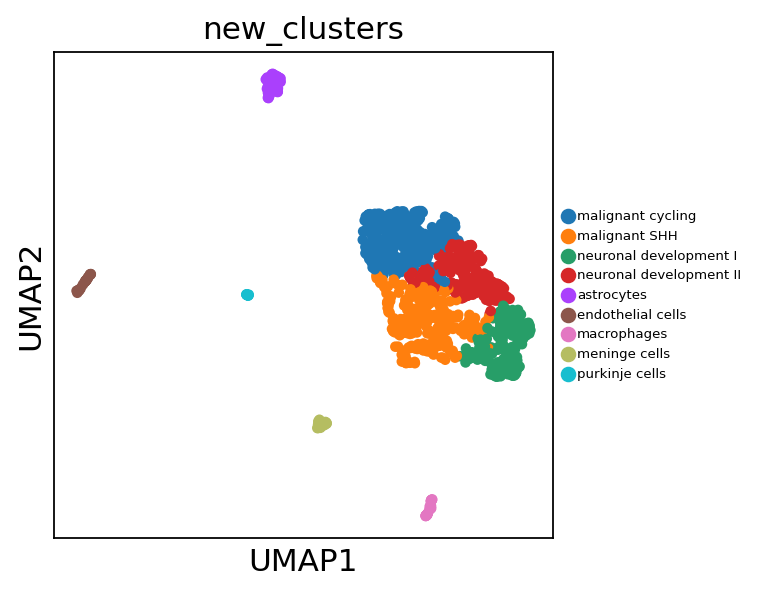

In [37]:
sc.pl.umap(adata, color=['new_clusters'], save = '_ST1R-Nuclei_Aurelie_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [38]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-Nuclei_Aurelie_Celltype_scanpy.h5ad")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [39]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-Nuclei_metadata.csv')

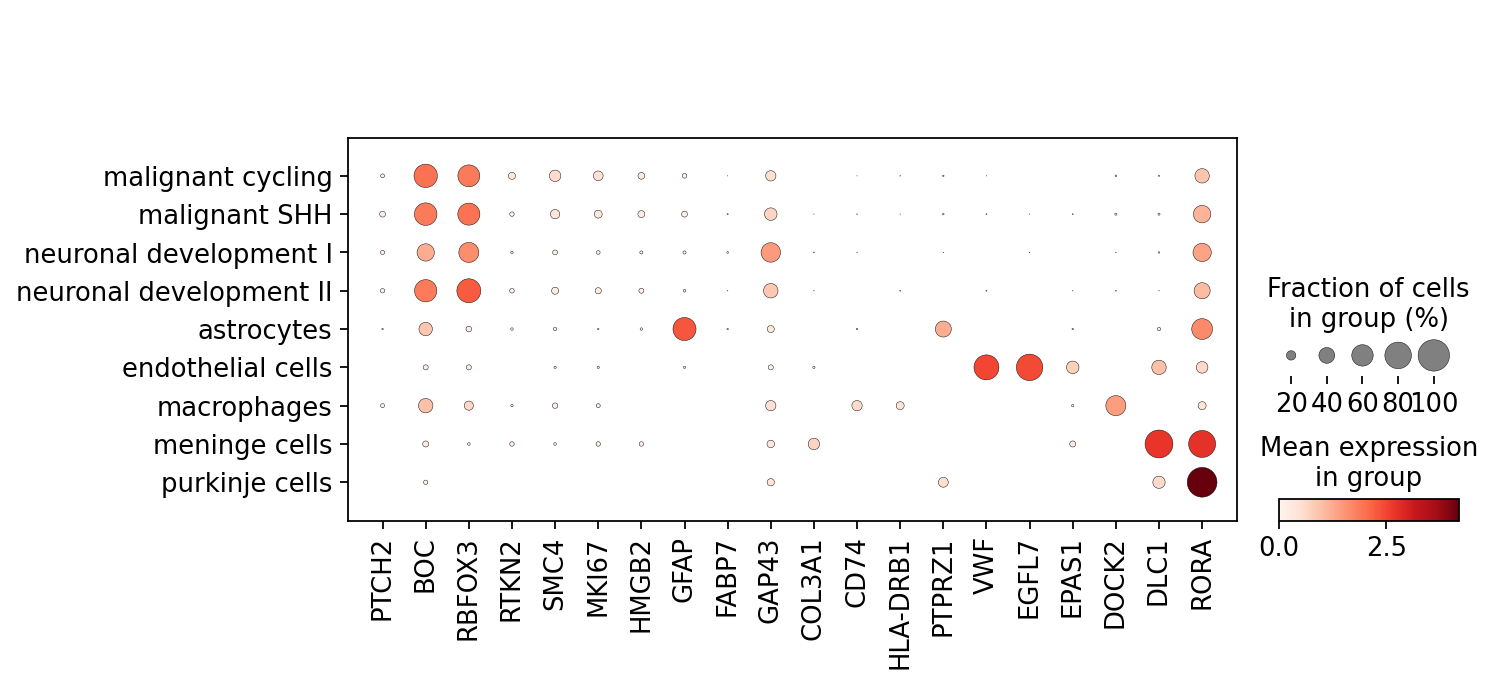

In [40]:
aurelie_marker_genes = ["PTCH2", "BOC", "RBFOX3", "RTKN2", "SMC4", "MKI67", "HMGB2", "GFAP", "FABP7",
                "GAP43", "COL3A1", "CD74", "HLA-DRB1", "PTPRZ1", "VWF", "EGFL7", "EPAS1", "DOCK2", "DLC1", "RORA"]

sc.pl.dotplot(adata, aurelie_marker_genes, groupby='new_clusters')

In [3]:
adata = sc.read("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/ST1R-Nuclei_Aurelie_Celltype_scanpy.h5ad")

## PROJECT ALIGNED SCDNA CLONES ONTO THE EMBEDDING

In [41]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-Nuclei/ST1R-Nuclei_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
CCACTACAGATCGGGT-1,Clone1,0.621818,0.621818,-0.024308,0.001,1.001,0,0.001,0.002
GCGAGAAAGCTGAAAT-1,Clone1,0.703916,0.703916,-0.024543,0.001,1.001,0,0.001,0.002
CTAACTTCACAGATTC-1,Clone1,0.565225,0.565225,-0.025564,0.001,1.001,0,0.001,0.002
CAGAGAGGTCACAAGG-1,Clone1,0.580292,0.580292,-0.025952,0.001,1.001,0,0.001,0.002
CTTACCGAGATGTTAG-1,Clone1,0.600924,0.600924,-0.026206,0.001,1.001,0,0.001,0.002
...,...,...,...,...,...,...,...,...,...
GTGTGCGGTTGGTTTG-1,Clone1,0.577496,0.577496,0.013686,0.001,1.001,0,0.001,0.002
ATGTGTGCATAGAAAC-1,Clone1,0.778104,0.778104,0.011803,0.001,1.001,0,0.001,0.002
TTTACTGGTGTAACGG-1,Clone1,0.477156,0.477156,-0.034134,0.001,1.001,0,0.001,0.002


In [42]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
CCACTACAGATCGGGT-1,Clone1,0.621818,0.621818,-0.024308,0.001,1.001,0,0.001,0.002
GCGAGAAAGCTGAAAT-1,Clone1,0.703916,0.703916,-0.024543,0.001,1.001,0,0.001,0.002
CTAACTTCACAGATTC-1,Clone1,0.565225,0.565225,-0.025564,0.001,1.001,0,0.001,0.002
CAGAGAGGTCACAAGG-1,Clone1,0.580292,0.580292,-0.025952,0.001,1.001,0,0.001,0.002
CTTACCGAGATGTTAG-1,Clone1,0.600924,0.600924,-0.026206,0.001,1.001,0,0.001,0.002
...,...,...,...,...,...,...,...,...,...
GTGTGCGGTTGGTTTG-1,Clone1,0.577496,0.577496,0.013686,0.001,1.001,0,0.001,0.002
ATGTGTGCATAGAAAC-1,Clone1,0.778104,0.778104,0.011803,0.001,1.001,0,0.001,0.002
TTTACTGGTGTAACGG-1,Clone1,0.477156,0.477156,-0.034134,0.001,1.001,0,0.001,0.002


In [43]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [44]:
adata.uns['clone_id_colors'] = np.array(["#377EB8", "#808080"])

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


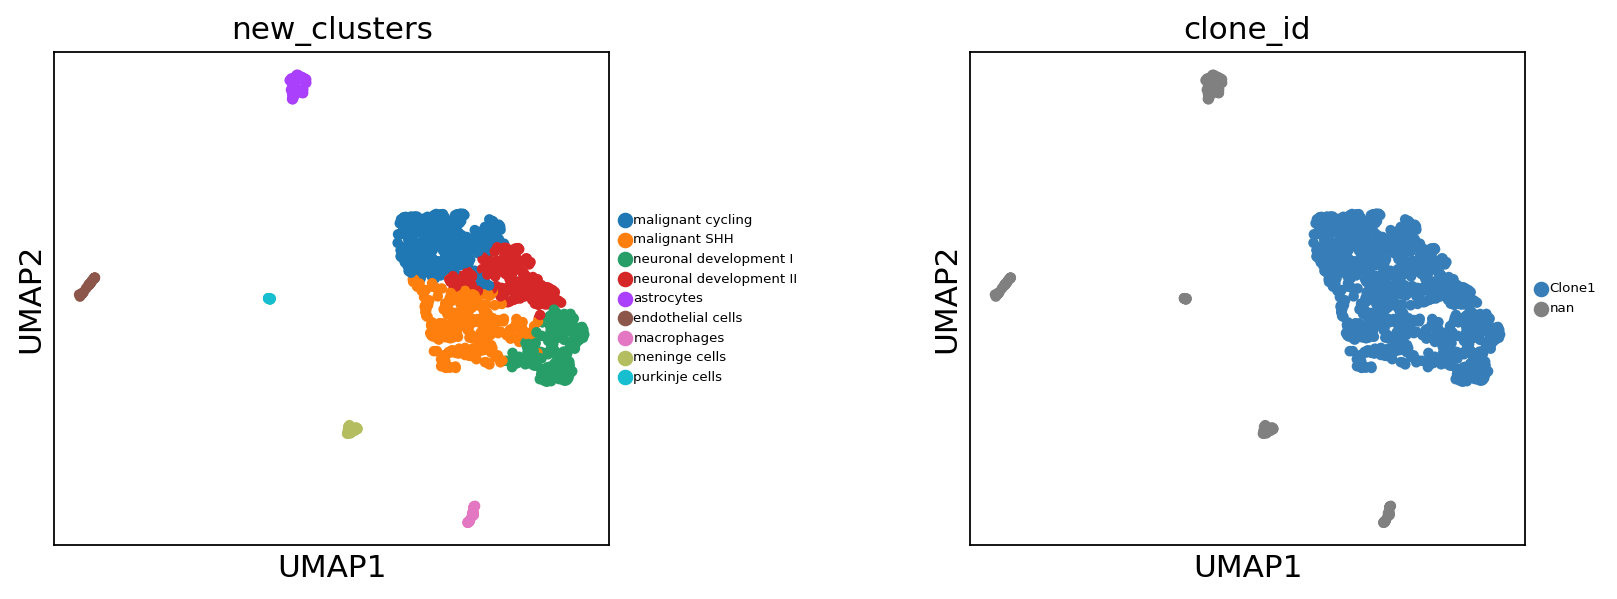

In [45]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_ST1R-Nuclei_scDNA_clones_integrated.pdf', wspace = 0.5, legend_fontsize = 6)

In [48]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/ST1R-Nuclei_aligned_scDNA_metadata.csv')

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


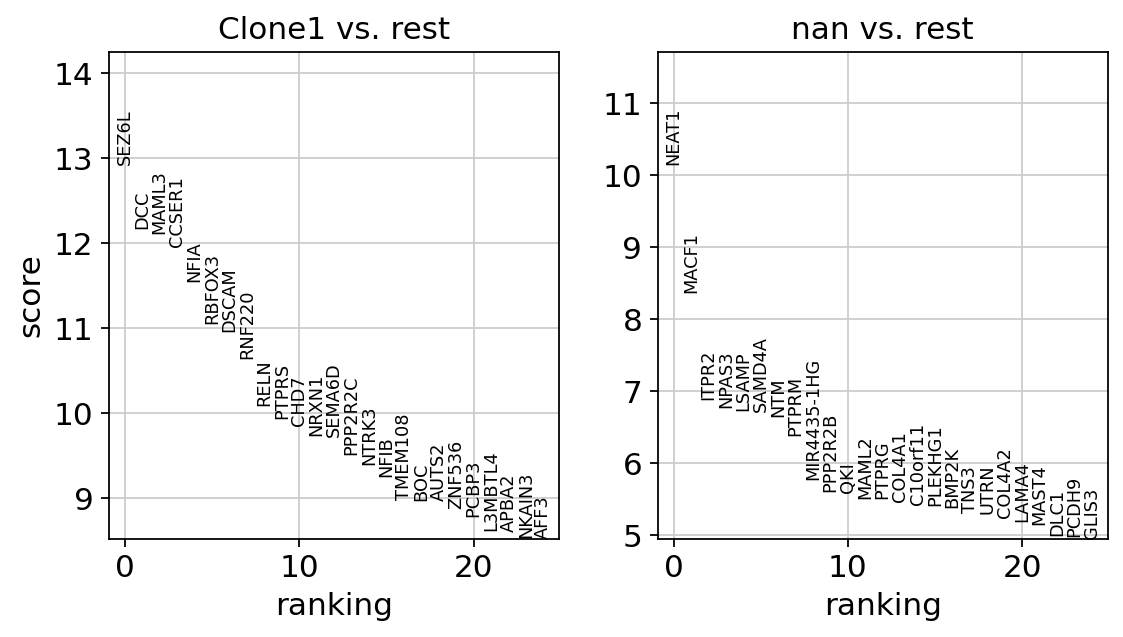

In [47]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups='all',
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [15]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'scores', "pvals", 'pvals_adj']})

In [49]:
wilcoxon_df.to_csv("//omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/ST1R-Nuclei_DEG_wilcoxon_integrated_scDNA_clones.csv")

In [50]:
wilcoxon_df

,0_n,0_s,0_l,0_p,1_n,1_s,1_l,1_p,2_n,2_s,...,6_l,6_p,7_n,7_s,7_l,7_p,8_n,8_s,8_l,8_p
0,NTRK3,8.506273,1.321853,2.953197e-13,RPL10,5.117642,1.162750,0.005087,CLSTN2,12.706237,...,8.582245,3.665016e-08,DLC1,7.439947,7.560623,1.656135e-09,SRRM3,5.773538,6.004097,0.000090
1,RP11-649A16.1,8.239794,1.044781,1.418189e-12,CALN1,4.832383,1.331358,0.011091,GRIK2,10.120961,...,5.891042,1.346399e-07,MIR4435-1HG,6.734024,7.323892,1.356743e-07,GRID2,5.715123,5.002470,0.000090
2,ARHGAP11B,8.117056,1.913037,2.617729e-12,SFRP1,4.602388,1.055506,0.022346,ERBB4,9.230843,...,3.761555,7.976269e-07,CDH11,6.657116,6.109679,1.530490e-07,MEG3,5.424106,7.276539,0.000220
3,TENM3,7.858593,1.178824,1.596821e-11,RBFOX1,4.547207,0.851770,0.022346,NRG1,9.041680,...,5.744688,2.077619e-05,UACA,6.375206,6.661718,7.510616e-07,SYN3,5.391028,6.848999,0.000220
4,AFF3,7.761669,1.144431,2.756304e-11,KCNIP4,4.376903,0.966423,0.039585,DPP6,8.962309,...,7.708921,2.717083e-05,RBPMS,5.833539,7.415077,9.913375e-06,KCNIP4,5.369562,4.302584,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16437,NRG1,-4.882579,-1.558465,9.061021e-04,DTNA,-2.356961,-0.602534,0.999849,GRID2,-5.003854,...,-2.951528,3.840107e-02,SEZ6L,-5.669283,-3.300009,2.039107e-05,DCC,-3.775831,-2.435801,0.097114
16438,ERBB4,-5.159722,-1.371535,2.541494e-04,PRKCA,-2.444868,-0.498780,0.999849,RNF220,-5.012465,...,-2.434814,3.360474e-02,AUTS2,-5.958579,-2.319649,5.229403e-06,TRIO,-3.890197,-3.745510,0.065875
16439,NEAT1,-5.421873,-0.831507,6.926538e-05,NFIB,-2.596806,-0.362409,0.999849,LINC00669,-5.618607,...,-1.809291,3.263606e-02,DSCAM,-6.002635,-4.753354,4.560084e-06,CASC15,-4.060514,-3.328962,0.040254
16440,CLSTN2,-5.742466,-1.377692,1.278469e-05,AFF3,-3.080169,-0.393790,0.829651,ARHGAP11B,-5.743654,...,-2.399930,7.816915e-03,DCC,-6.163327,-2.899235,1.952002e-06,SEZ6L,-4.144969,-4.015967,0.029410


## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [9]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [10]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [11]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [12]:
len(gene_list_pos)

48

In [13]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [14]:
len(gene_list_neg)

136

In [15]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    895 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    3141 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


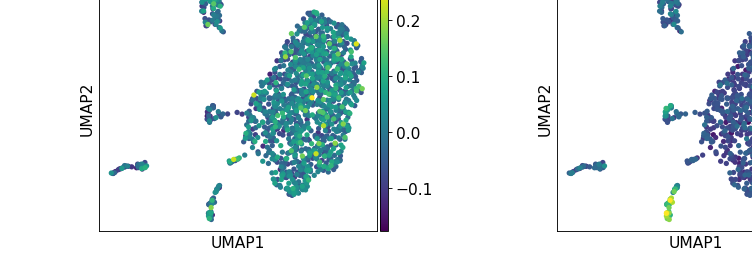

In [16]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_ST1R-Nuclei_chromothripsisScore.pdf', wspace = 0.5)

In [17]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-Nuclei_chromothripsisScore_metadata.csv')

In [18]:
metadata

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,min_pval,Upregulated_Chromothripsis_Score,Downregulated_Chromothripsis_Score
AAACCTGAGCACCGCT-1,ST1R,Nuclei,ST,False,0.058513,-14.350538,447,446,525.0,0.0,0.000000,2.0,0.380952,2,cluster1,malignant SHH,Clone1,0.001,-0.052486,0.023337
AAACCTGGTGATAAGT-1,ST1R,Nuclei,ST,False,0.115483,-6.036352,3933,3900,7795.0,29.0,0.372033,35.0,0.449006,1,cluster0,malignant cycling,Clone1,0.001,-0.016526,-0.118671
AAACCTGGTGCGAAAC-1,ST1R,Nuclei,ST,False,0.095485,-7.828092,580,575,682.0,4.0,0.586510,9.0,1.319648,0,cluster0,malignant cycling,Clone1,0.001,-0.009154,-0.065980
AAACGGGTCGAGAGCA-1,ST1R,Nuclei,ST,False,0.087379,-8.788703,456,451,572.0,10.0,1.748252,5.0,0.874126,6,cluster6,macrophages,nan,NaN,-0.133194,0.119966
AAACGGGTCGTCTGCT-1,ST1R,Nuclei,ST,False,0.030928,-28.995586,406,405,563.0,9.0,1.598579,16.0,2.841918,1,cluster3,neuronal development II,Clone1,0.001,0.134260,-0.056374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATTCGACA-1,ST1R,Nuclei,ST,False,0.182609,-2.917936,3356,3332,6116.0,25.0,0.408764,38.0,0.621321,1,cluster1,malignant SHH,Clone1,0.001,-0.058431,-0.087212
TTTGTCAGTCCGAGTC-1,ST1R,Nuclei,ST,False,0.026915,-33.496473,438,436,629.0,0.0,0.000000,5.0,0.794913,2,cluster2,neuronal development I,Clone1,0.001,-0.011838,-0.080763
TTTGTCAGTTTGTTGG-1,ST1R,Nuclei,ST,False,0.073892,-10.852097,428,427,502.0,0.0,0.000000,5.0,0.996016,1,cluster3,neuronal development II,Clone1,0.001,0.054603,-0.072301
TTTGTCATCCGCAGTG-1,ST1R,Nuclei,ST,False,0.080235,-9.795756,480,479,574.0,1.0,0.174216,3.0,0.522648,0,cluster0,malignant cycling,Clone1,0.001,-0.066594,-0.059303


In [19]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id                 Clone1  nan   
new_clusters                           
malignant cycling           371       0
malignant SHH               327       0
neuronal development I      239       0
neuronal development II     220       0
astrocytes                    0      59
endothelial cells             0      34
macrophages                   0      31
meninge cells                 0      27
purkinje cells                0      14


In [20]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/ST1R-Nuclei_contingencyTable_celltypes_clones.csv')